In [5]:
!pip install xarray rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 793.8 kB/s eta 0:00:00 0:00:01


In [11]:
import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping


# Download data and set working directory
#data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'vector_data'
                     ))

In [12]:
sentinel_data_path = os.path.join("/home/jovyan/",
                                      "satData/wiz"
                                      #"satData/S2B_MSIL2A_20230612T073619_N0509_R092_T37NCC_20230612T101141.SAFE/GRANULE/L2A_T37NCC_A032722_20230612T075442/",
                                      #"IMG_DATA",
                                      #"R10m"
                                     # "RGB"
                                  )

glob(os.path.join(sentinel_data_path, "*"))


all_sentinel_bands = glob(os.path.join(sentinel_data_path,
                                          "*B*.jp2"))
                                        # "*TCI*.jp2"))
all_sentinel_bands.sort()

all_sentinel_bands


['/home/jovyan/satData/wiz/T32UNB_20230906T102601_B02_10m.jp2',
 '/home/jovyan/satData/wiz/T32UNB_20230906T102601_B03_10m.jp2',
 '/home/jovyan/satData/wiz/T32UNB_20230906T102601_B04_10m.jp2',
 '/home/jovyan/satData/wiz/T32UNB_20230906T102601_B08_10m.jp2']

In [13]:
def open_clean_band(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    return rxr.open_rasterio(band_path, masked=True).squeeze()

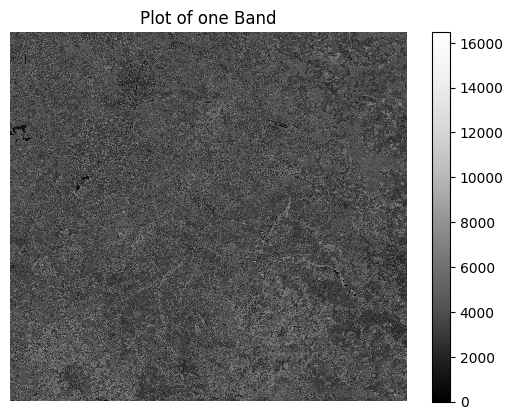

In [14]:
sentinel_xr = open_clean_band(all_sentinel_bands[3])

# Plot the data
f, ax = plt.subplots()
sentinel_xr.plot.imshow(cmap="Greys_r",
                            ax=ax)
ax.set_title("Plot of one Band")
ax.set_axis_off()
plt.show()

In [17]:
aoi_boundary

,geometry


In [20]:
#clipped_xarray = xarray_name.rio.clip(geopandas_object_name.geometry)

crs = es.crs_check(all_sentinel_bands[0])

# Open up boundary extent using GeoPandas
#aoi_boundary_path = os.path.join("aoi.gpkg")
aoi_boundary_path = os.path.join("/home/jovyan/vector_data/wiz.gpkg")

aoi_boundary = gpd.read_file(aoi_boundary_path)

crs_sat = es.crs_check(all_sentinel_bands[0])
crs_aoi = aoi_boundary.crs
print (crs_sat)
print (crs_aoi)

EPSG:32632
EPSG:4326


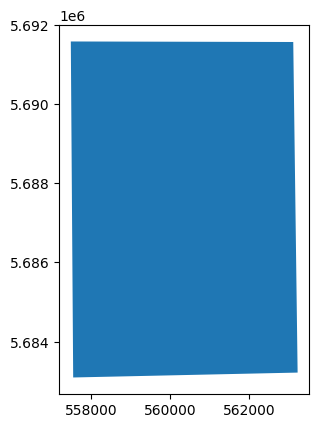

In [21]:
# Reproject data to CRS of raster data
aoi_boundary_reprojected = aoi_boundary.to_crs(crs_sat)
aoi_boundary_reprojected.plot()
plt.show()

In [22]:
sentinel_xr_clip = rxr.open_rasterio(all_sentinel_bands[0]).rio.clip(
    aoi_boundary_reprojected.geometry,
    from_disk=True).squeeze()

# Notice the x and y data dimensions of your data have changed
sentinel_xr_clip

<xarray.DataArray (y: 849, x: 574)>
array([[   0, 1439, 1534, ...,    0,    0,    0],
       [   0, 1412, 1469, ...,    0,    0,    0],
       [   0, 1416, 1472, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)
Coordinates:
  * x            (x) float64 5.575e+05 5.575e+05 ... 5.632e+05 5.632e+05
  * y            (y) float64 5.692e+06 5.692e+06 ... 5.683e+06 5.683e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

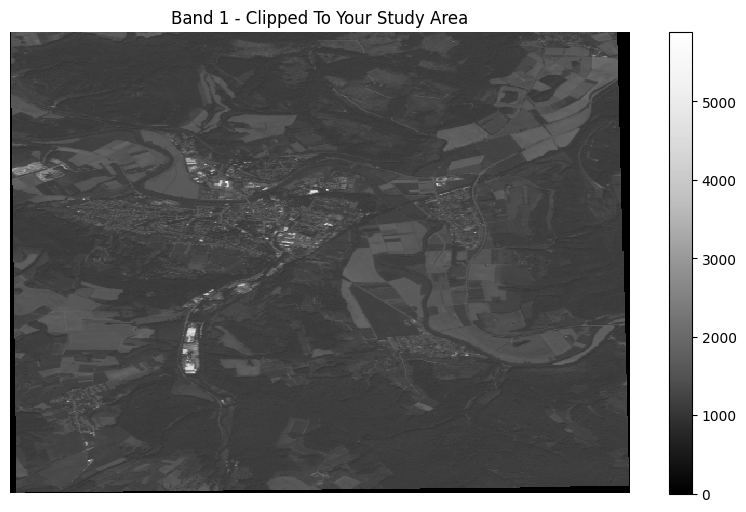

In [23]:
# Plot the data
f, ax = plt.subplots(figsize=(10, 6))
sentinel_xr_clip.plot.imshow(cmap="Greys_r",
                                 ax=ax)
ax.set_axis_off()
ax.set_title("Band 1 - Clipped To Your Study Area")
plt.show()

In [24]:
# Clean the data
valid_range = (0, 20000)
# Only run this step if a valid range tuple is provided
if valid_range:
    mask = ((sentinel_xr_clip < valid_range[0]) | (
        sentinel_xr_clip > valid_range[1]))
    sentinel_xr_clip = sentinel_xr_clip.where(
        ~xr.where(mask, True, False))

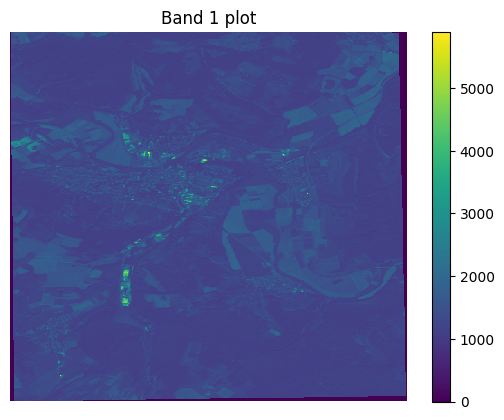

In [25]:
f, ax = plt.subplots()
sentinel_xr_clip.plot(ax=ax)
ax.set_title("Band 1 plot")
ax.set_axis_off()
plt.show()


In [26]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((sentinel_xr_clip < valid_range[0]) | (
            sentinel_xr_clip > valid_range[1]))
        cleaned_band = sentinel_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band


In [27]:
#putting ist all together
band_path = all_sentinel_bands[0]

clip_extent = aoi_boundary_reprojected

#open_clean_band(band_path, clip_extent, valid_range=None)

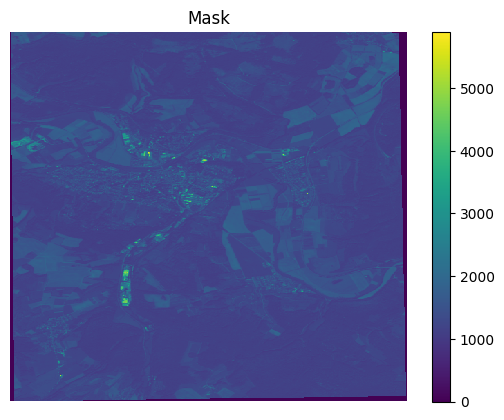

In [28]:
cleaned_band = open_clean_band(band_path, clip_extent, valid_range=None)

f, ax = plt.subplots()
cleaned_band.plot(ax=ax)
ax.set_title("Mask")
ax.set_axis_off()
plt.show()

In [30]:
# Open up boundary extent using GeoPandas

aoi_boundary_path = os.path.join("wiz.gpkg")
aoi_boundary = gpd.read_file(aoi_boundary_path)

# Get a list of required bands - bands 2 through 5
all_sentinel_data_bands = glob(os.path.join(sentinel_data_path,
                                           "*B[02-08]*.jp2"))
                                          #  "*TCI*.jp2"))
all_sentinel_data_bands.sort()
all_sentinel_data_bands

['/home/jovyan/satData/wiz/T32UNB_20230906T102601_B02_10m.jp2',
 '/home/jovyan/satData/wiz/T32UNB_20230906T102601_B03_10m.jp2',
 '/home/jovyan/satData/wiz/T32UNB_20230906T102601_B04_10m.jp2',
 '/home/jovyan/satData/wiz/T32UNB_20230906T102601_B08_10m.jp2']

In [31]:
# Reproject your vector layer
crs_sat = es.crs_check(all_sentinel_data_bands[0])

crs_aoi = aoi_boundary.crs

# Reproject fire boundary for clipping
aoi_reprojected = aoi_boundary.to_crs(crs_sat)

In [32]:
post_all_bands = []
for i, aband in enumerate(all_sentinel_data_bands):
    cleaned = open_clean_band(aband, aoi_reprojected, valid_range=None)
    # This line below is only needed if you wish to stack and plot your data
    #cleaned["band"] = i+1
    cleaned.rio.to_raster(
        "/home/jovyan/results/bands_cropped/"+str(i)+"cropped_to_aoi.tiff",
        tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
        windowed=True,  # rioxarray: read & write one window at a time
    )
    post_all_bands.append(cleaned)

# OPTIONAL - Stack the data
post_ngurunit_stack = xr.concat(post_all_bands, dim="band")
#post_ngurunit_stack

In [35]:
## use earthpy (see below)
# Plot the final stacked data
post_ngurunit_stack.plot.imshow(col="band",
                            col_wrap=4,
                            cmap="Greys_r")
plt.show()

ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.

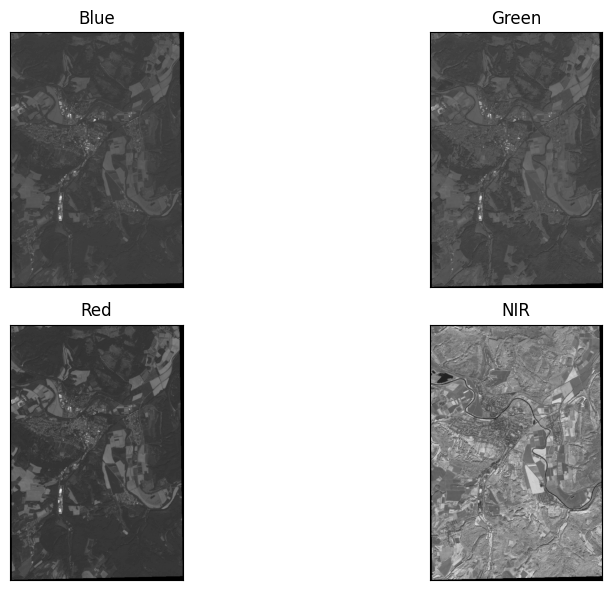

In [36]:
# Plot using earthpy
band_titles = ["Blue",
               "Green",
               "Red",
               "NIR"
               ]

ep.plot_bands(post_ngurunit_stack,
              figsize=(11, 6),
              cols=2,
              title=band_titles,
              cbar=False)
plt.show()

In [1]:

def process_bands(paths, crop_layer, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).
    
    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.
        
    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        #cleaned["band"] = i+1
        #cleaned.rio.to_raster(
        #    "/home/jovyan/results/bands_cropped/"+str(i)+"cropped_to_aoi.tiff",
        #    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
        #    windowed=True,  # rioxarray: read & write one window at a time
        #)
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        allBandStack = xr.concat(all_bands, dim="band")
        
        #with rio.open(paths[0]) as src:
        #    meta = src.meta
        #with rio.open('/home/jovyan/results/bands_cropped/allbands_croppped.tiff', 'w', **meta) as dst:
        #    dst.write(arr_st, indexes=4)
                
        return allBandStack
    else:
        print("Returning a list of xarray objects.")
        return all_bands
        
# Open up boundary extent using GeoPandas
#aoi_boundary_path = os.path.join("aoi.gpkg")
aoi_boundary_path = os.path.join("wiz.gpkg")
aoi_boundary = gpd.read_file(aoi_boundary_path)

# Get a list of required bands - bands 2 through 5
all_sentinel_bands = glob(os.path.join(sentinel_data_path,
                                           "*B[02-08]*.jp2"))
                                           #"*TCI*.jp2"))
all_sentinel_bands.sort()

# Get CRS of landsat data and reproject fire boundary
# Reproject your vector layer
crs_sat = es.crs_check(all_sentinel_bands[0])
crs_aoi = aoi_boundary.crs

# Reproject aoi boundary for clipping
aoi_reprojected = aoi_boundary.to_crs(crs_sat)

DriverError: wiz.gpkg: No such file or directory

In [41]:
processed_stack = process_bands(all_sentinel_bands, 
                                aoi_reprojected, 
                                stack=True)
processed_stack.shape

I'm stacking your data now.


(4, 849, 574)

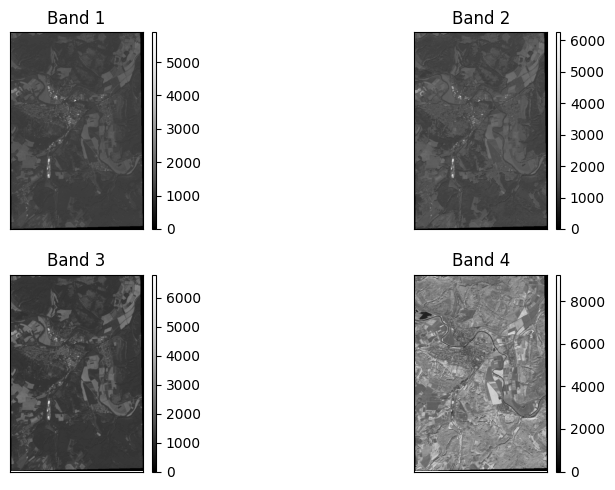

<Figure size 640x480 with 0 Axes>

In [42]:
# Plot using earthpy
band_titles = ["Blue Band",
               "Green Band",
               "Red Band",
               "NIR Band"]

# Plot the final data
ep.plot_bands(processed_stack,
              cols=2,
              figsize=(10,5))
plt.suptitle("Cleaned and Cropped Sentinel Bands")
plt.show()

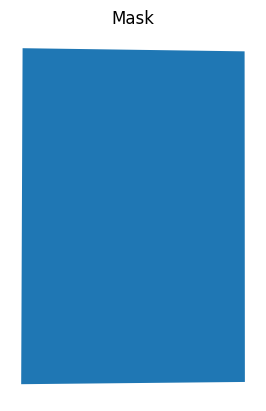

In [43]:
f, ax = plt.subplots()
aoi_boundary.plot(ax=ax)
ax.set_title("Mask")
ax.set_axis_off()
plt.show()

In [147]:
len(aoi_boundary)

1

In [44]:
processed_stack.rio.to_raster(
    "/home/jovyan/results/WIZcropped4bands_to_aoi.tiff",
    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    windowed=True,  # rioxarray: read & write one window at a time
)